#### @author: Александр Владимирович Толмачев | axtolm@gmail.com
<hr>

## 3. Предобработка данных на Python

## Часть 2. Работа с выбросами в данных

### На этом занятии мы планируем научиться:
- Находить выбросы в данных и исправлять их.

### 1. Вводная информация

Выброс (outlier) — в статистике это элемент выборки, существенно отличающийся от остальных.

Статистический метод, способный действовать в условиях выбросов, называется робастным.<br>
Медиана является робастной характеристикой, а среднее по выборке — нет. 

Причины появления выбросов:
- ошибки измерений, 
- ошибки формирования выборки (попадание элементов из другой генеральной совокупности), 
- преднамеренное искажение или некорректная фиксация результатов анализа выборки, 
- ошибочные предположения о распределении данных или модели, 
- малое количество наблюдений и т.д.

**Необходимо уметь выявлять и исправлять выбросы.**<br>
Анализ выбросов ведет к более полному пониманию изучаемых процессов и более глубокому анализу данных.

### 2. Загрузка данных из файла в csv формате в таблицу pandas DataFrame

**Для примера возьмем датасет с открытыми экономическими данными для региона Свердловская область за 2015-2018 гг**<br>
**Поля (столбцы) таблицы**<br>
- "date" - дата, для которой приведены экономические показатели, в формате str,
- "avg_salary" - средняя зарплата,
- "avg_pension" - средняя пенсия,
- "avg_card_spend" - средние расходы по картам. 

Для загрузки воспользуемся методом `pandas.read_csv`<br>
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html<br>

In [1]:
# зададим имя файла с пропущенными данными (лежит в той же папке)
in_file_name = 'dataset_2_outliers.csv'

In [2]:
import pandas as pd    # импорт библиотеки

Загрузим в DataFrame файл данных в формате csv `in_file_name`, имеющий выбросы. 
Т.к. файл лежит там же, где и `.ipynb`, то полный путь можно не указывать. 

In [3]:
df_in = pd.read_csv(in_file_name, sep = ';')

In [4]:
df_in.head(3)    # выведем данные на экран - первые три строки

,date,avg_salary,avg_pension,avg_card_spend
0,15.01.2015,19209,8831,7927
1,15.02.2015,25356,10451,7605
2,15.03.2015,24159,10284,8600


Преобразуем дату из числа во временной формат с помощью метода `pandas.to_datetime`(формат `%d.%m.%Y` укажем явно )<br>
https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html<br>
Иначе на графиках она будет отображаться некорректно, т.к. имеет формат `str`.

In [5]:
type(df_in.date.iloc[0])     # тип до преобразования

str

In [6]:
df_in.date = pd.to_datetime(df_in.date, format = '%d.%m.%Y')

In [7]:
type(df_in.date.iloc[0])    # тип после преобразования

pandas._libs.tslibs.timestamps.Timestamp

### 3. Обнаружение выбросов

Обнаружить выбросы, глядя на таблицу с данными сложно - строк может быть много, числа не визуальны. Нужны другие способы.

**Способ 1. Визуально по графику**

Рассмотрим каждый столбец таблицы как временной ряд и визуализируем его с помощью метода `plot.scatter` библиотеки `pandas`.
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.scatter.html

**График для `avg_salary` - средняя зарплата**

<AxesSubplot:xlabel='date', ylabel='avg_salary'>

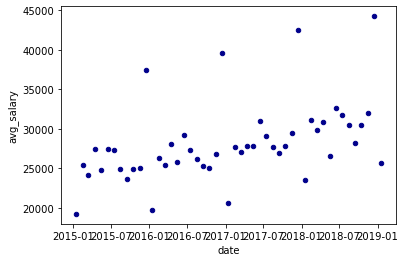

In [8]:
df_in.plot.scatter(x = 'date', y = 'avg_salary', c = 'DarkBlue') # график от времени 

Визуально на графике есть точки, подозрительные на выбросы - 4 верхние и 5 нижних точек.<br>
С помощью фильтрации по значению выделим некоторые из них и выведем на экран.<br>
Границы фильтрации `35000` и `23000` определим визуально по графику (субъективность тут имеет место).

In [9]:
df_in[((df_in.avg_salary > 35000) | (df_in.avg_salary < 23000))][['date','avg_salary']]

,date,avg_salary
0,2015-01-15,19209
11,2015-12-15,37467
12,2016-01-15,19760
23,2016-12-15,39630
24,2017-01-15,20626
35,2017-12-15,42513
47,2018-12-15,44268


Видим, что это зарплаты декабря (выброс вверх) и зарплаты января (выброс вниз).<br>
Слушателям из России предлагается подумать и объяснить природу их возникновения.

**График для `avg_pension` - средняя пенсия**

<AxesSubplot:xlabel='date', ylabel='avg_pension'>

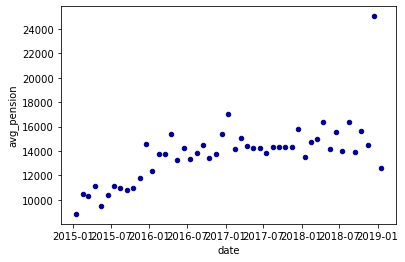

In [10]:
df_in.plot.scatter(x='date', y='avg_pension', c='DarkBlue') # график от времени

Визуально подозрительны на выбросы последние две точки временного ряда.<br>
Выделим их с помощью фильтрации по времени (возьмем последние две точки, воспользуемся `iloc` и сделаем срез)

In [11]:
df_in[['date','avg_pension']].iloc[-2:]

,date,avg_pension
47,2018-12-15,25044
48,2019-01-15,12607


**График для `avg_card_spend` - средние расходы по картам** 

<AxesSubplot:xlabel='date', ylabel='avg_card_spend'>

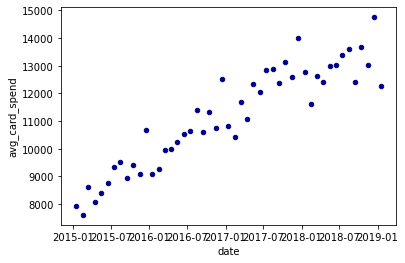

In [12]:
df_in.plot.scatter(x='date', y='avg_card_spend', c='DarkBlue') # график от времени

Визуально тут нет точек, подозрительных как выбросы.

**Способ 2. С помощью диаграммы box plot (ящик с усами или диаграмма размаха)**

Диаграмма часто используется в описательной статистике для компактного изображения одномерного распределения вероятностей.

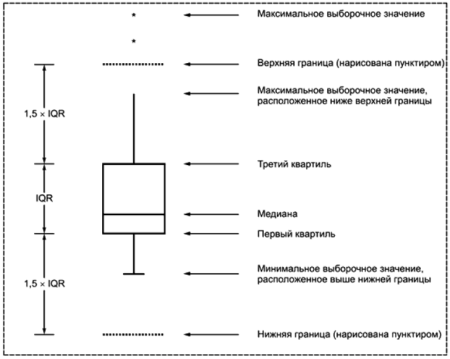

**IQR** (interquartile range) - межквартильный размах, разность третьего квартиля и первого квартиля.<br>
Содержит 50% данных из выборки, разделенных медианой.<br><br>
Для определения границ "усов" используют формулу $X_1 = Q_1 - k(Q_3 - Q1)$, $X_2 = Q_3 + k(Q_3 - Q1)$<br>
$k$ обычно берут $1.5$. Такой boxplot в случае нормального распределения покрывает $2.7\sigma$, что наиболее близко к $3\sigma$ или $99.7%$ выборки.<br><br>
**Все, что меньше $X_1$ и больше $X_2$, расценивается как выбросы**<br><br>
Воспользуемся методом `boxplot` из библиотеки `pandas` для построения диаграммы<br>
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.boxplot.html<br>
Нужные колонки можно указать в явном виде.<br>
Метод имеет параметр `return_type{‘axes’, ‘dict’, ‘both’}, default ‘axes’`, который определяет, что выдаст метод на выходе - только график, только данные, график и данные.

In [13]:
# импорт графических библиотек
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn')

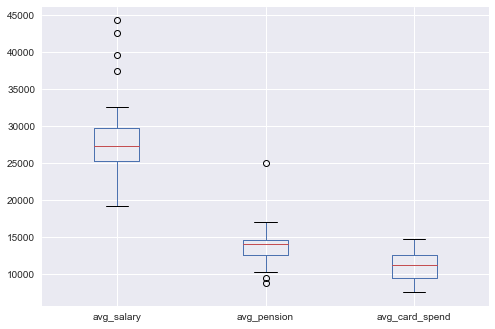

In [14]:
_, bp_axes = df_in.boxplot(column=['avg_salary', 'avg_pension', 'avg_card_spend'], return_type='both')    # график и данные

**Что видим?**<br>
- "avg_salary" - обнаружены только 4 выброса вверх (визуально определили 4 вверх и 5 вниз),
- "avg_pension" - обнаружены 2 выброса вниз и 1 вверх (визуально определили 1 вверх и 1 вниз),
- "avg_card_spend" - выбросы не обнаружены (как и визуально).

**Как получить численные значения выбросов?**

In [15]:
outliers_list = [flier.get_ydata() for flier in bp_axes["fliers"]]    # выбросы
print(outliers_list)    # выведем все на экран
print("avg_pension outliers: ",list(outliers_list[1]))    # выбросы конкретно по "avg_pension"

[array([37467, 39630, 42513, 44268], dtype=int64), array([ 8831,  9496, 25044], dtype=int64), array([], dtype=int64)]
avg_pension outliers:  [8831, 9496, 25044]


**Способ 3. Фильтр Хэмпеля (Hampel filter)**

В предлагаемой реализации фильтр признает выбросами все значения из выборки, у которых разница с медианой, рассчитанной по всей выборке, больше, чем 3 медианных абсолютных отклонения. В общем случае задают размер "окна" для расчета медианы и количество медианных абсолютных отклонений (у нас взято 3).

Напишем функцию, реализующую фильтр Хемпеля. <br>
Вход - одномерный массив данных. <br>
Выход - входной массив данных, в котором выбросы заменены на пропуски (NaN).<br>

In [16]:
def hampel_filter(data_in):
    import numpy as np    # импорт библиотеки
    data_out = data_in.copy()    # сделаем копию исходных данных и из нее сделаем массив на выход
    diff_array = np.abs(data_out.median() - data_out)   # массив разностей исходных данных с медианой
    mad = diff_array.median()    # mad = median_abs_deviation - медиана по разностям с предыдущего шага
    outliers_id = diff_array > 3*mad    # массив из True - если разность с медианой > 3 x mad и False, если меньше
    data_out[outliers_id] = np.nan    # в выходном массиве проставим NaN там, где True
    return(data_out)

Испытаем фильтр на наших данных - добавим в исходный DataFrame три новые колонки, полученные с помощью фильтра Хемпеля. Выполним расчет для каждой колонки.

In [17]:
df_in['avg_salary_hampel'] = list(hampel_filter(df_in.avg_salary))
df_in['avg_pension_hampel'] = list(hampel_filter(df_in.avg_pension))
df_in['avg_card_spend_hampel'] = list(hampel_filter(df_in.avg_card_spend))

Для удобства восприятия перегруппируем в выводе на экран колонки таблицы.

In [18]:
df_in[['date','avg_salary','avg_salary_hampel','avg_pension','avg_pension_hampel','avg_card_spend','avg_card_spend_hampel']]

,date,avg_salary,avg_salary_hampel,avg_pension,avg_pension_hampel,avg_card_spend,avg_card_spend_hampel
0,2015-01-15,19209,NaN,8831,NaN,7927,7927
1,2015-02-15,25356,25356.0,10451,NaN,7605,7605
2,2015-03-15,24159,24159.0,10284,NaN,8600,8600
3,2015-04-15,27430,27430.0,11135,NaN,8085,8085
4,2015-05-15,24726,24726.0,9496,NaN,8413,8413
5,2015-06-15,27387,27387.0,10361,NaN,8748,8748
6,2015-07-15,27372,27372.0,11083,NaN,9353,9353
7,2015-08-15,24915,24915.0,10922,NaN,9504,9504
8,2015-09-15,23616,23616.0,10828,NaN,8925,8925
9,2015-10-15,24943,24943.0,10991,NaN,9417,9417


Фильтр неплохо сработал на `avg_salary` - нашел выбросы вниз, на `avg_card_spend` - не нашел там выбросов.<br> 
Фильтр плохо сработал на `avg_pension` - определил как выбросы все начало ряда. 

**Что можно использовать для выявления выбросов еще?**

- диаграмму рассеяния типа `avg_salary - avg_card_spend` (ранее мы рассматривали одномерные величины)

<AxesSubplot:xlabel='avg_salary', ylabel='avg_card_spend'>

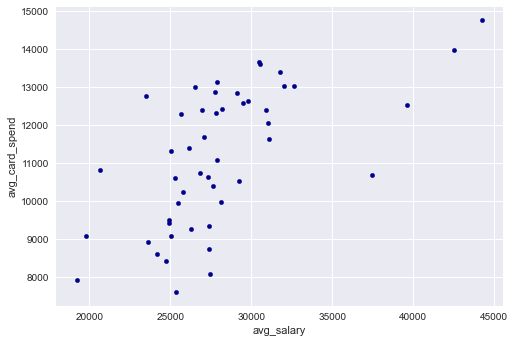

In [19]:
df_in.plot.scatter(x='avg_salary', y='avg_card_spend', c='DarkBlue') # диаграмма рассеяния

Здесь тоже видны выбросы.<br>
Диаграммы рассеяния важны при исследовании взаимосвязи величин, например, с помощью регрессии, которая чувствительна к выбросам.

- модель, описывающую взаимосвязь величин, например, линейную регрессию - по ее остаткам можно выявлять выбросы.
- другие количественные критерии типа Шовене, Граббса, Пирса.

### 4. Исправление выбросов

**Как можно исправить выбросы?**

**Способ 1.** Их можно удалить. Если таблица данных имеет несколько столбцов, то можно удалять выбросы:
- В каждом столбце отдельно (в этом случае мы получим несколько столбцов разной длины). Такой вариант применим, если мы не планируем сопоставлять данные из разных столбцов.
- Во всей таблице в целом (в этом случае данны останутся синхронизированными по строкам). Такой вариант годится, если мы планируем изучать взаимосвязь между данными в разных столбцах.

**Способ 2.** Их можно заменить на какие-либо приемлемые значения (например, взять среднее между предыдущим и последующим значениями).<br> 

Нетрудно заметить, что данные способы аналогичны исправлению пропусков.<br>
Если заменить выбросы на NaN, то к ним можно будет применить методы удаления и замены, рассмотренные на занятии<br> `3. Предобработка данных на Python | Часть 1. Работа с пропусками в данных`

### Подведем итоги. На этом занятии мы научились:
- Находить выбросы в данных и исправлять их.